# Diagnostics, overfitting and feature selection

## Feature selection

In case the statistical significance of the impact of the considered regressors is being questioned, or  multicollinearity or overfitting is observed, reducing complexity of the model (number of features or their dimensionality) is usually recommended. The most straighforward way of doing so is through feature selection. 

This can be done by selecting a subset of the regressors of the given size $k$ maximizing the model fit ($R^2$) over the validation sample. Two common ways of doing that are
- Step-backward: keep removing regressors (one by one) having the highest negative or lowest positive impact on the validation $R^2$, until a target number of features is reached or until validation $R^2$ can not be improved anymore;
- Step-forward: keep adding regressors (one by one) having the maximal positive impact or minimal negative impact on the validation $R^2$, until a target number of features is reached or until validation $R^2$ can not be improved anymore.

Those are not the only two ways - one can also consider more sophisticated heursitics for the selection of the best combination of the regressors. 

Drawback - by removing regressors we're discarding information from the feature space, while it could happen that both - noise as well as important information - are spread among all the regressors.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import statsmodels.formula.api as smf

from scipy.stats import t

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = 'data/'
matplotlib.rcParams['figure.figsize'] = [10,4]

### An artificial example to demonstrate feature selection based on maximizing validation $R^2$, rather than p-values

The regular $R^2$:
$$
R^2=1-\frac{RSS}{\sum_i (y_i-\bar{y})^2}=\frac{\sum_i (\hat{y}_i-\bar{y})^2}{\sum_i (y_i-\bar{y})^2},
$$
The adjusted $R^2$:
$$
adj.R^2=1-\frac{RSS}{\sum_i (y_i-\bar{y})^2} \cdot \frac{N-1}{N-P-1} 
$$
where $N$ is the total sample size and $P$ is the number of features/selected variables

In [3]:
n = 15
np.random.seed(2)

col = []
for i in range(n):
    col.append('x%d'%(i+1))

X = pd.DataFrame(np.random.randn(50*n).reshape(50,n))
Y = X.iloc[:,[3,5,7]].sum(axis = 1) + 0.7*np.random.randn(50)
data3 = pd.concat((Y,X), axis = 1)  # concatenate Y and X
data3.columns = ['Y'] + col         # rename the columns

In [4]:
# The regression function based on the feature selection
def AdjR2(flag):
    '''
    Evalute the model with adjusted R-squared,
    with flag indicating the feature selection
    1--feature included
    0--feature excluded
    '''
    formstr='Y~-1'
    for i in range(len(flag)):
        if flag[i]==1:
            formstr += '+x%d'%(i+1) # Construct the regression formula based on flag
    train = data3[:20]
    valid = data3[20:]
    lm = smf.ols(formula = formstr, data = train).fit()
    lmy = lm.predict(valid)
    y_err = lmy-valid.Y
    y_norm = valid.Y-mean(valid.Y)
    # Adjusted R^2
    R2_OS = 1 - y_err.dot(y_err) / y_norm.dot(y_norm) * (n-1) / (n-sum(flag)-1)
    return lm, R2_OS

### Revisit the overfitting:

In [5]:
adjR2 = []
regR2 = []
OSR2 = []
for i in range(1, n):
    lm, r = AdjR2([1]*i + [0]*(n-i))
    regR2.append(lm.rsquared)
    adjR2.append(lm.rsquared_adj)
    OSR2.append(r)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


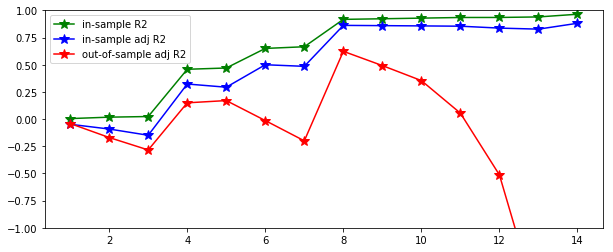

In [6]:
# In sample R2
plt.plot(range(1, n), regR2, 'g-*', markersize = 10)
plt.plot(range(1, n), adjR2, 'b-*', markersize = 10)
plt.plot(range(1, n), OSR2, 'r-*', markersize = 10)
plt.ylim((-1,1))
plt.legend(('in-sample R2','in-sample adj R2','out-of-sample adj R2'))

In [7]:
# Feature selection based on the p-values
def DropP(threshold = 1):
    '''Drop all features with p-values higher than the threshold'''
    flag_p = (AdjR2([1]*n)[0]).pvalues < threshold
    print('Validation R^2 is %f'%AdjR2(flag_p)[1])
    print(AdjR2(flag_p)[0].summary())

### First of all, let's try to include all features and observe their p-values
Note that if we include them all, we have a nagative one (N-N-1) in the denominator (since N = K), 
$$
adj.R^2=1-\frac{RSS}{\sum_i (y_i-\bar{y})^2} \cdot \frac{N-1}{N-K-1} 
$$
which simply flips the sign of the second term of the right hand side, making the adjusted $R^2$ ridiculously high

In [8]:
DropP(0.05)

Validation R^2 is -0.045484
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     12.10
Date:                Tue, 01 Oct 2019   Prob (F-statistic):           0.000468
Time:                        10:58:25   Log-Likelihood:                -34.745
No. Observations:                  20   AIC:                             73.49
Df Residuals:                      18   BIC:                             75.48
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x4             0.9464   

### Next we try to select feature in a fashion that maximizing validation adjusted $R^2$

In [9]:
# Find the best feature selection (forward step-wise) that maximizes the out-of-sample adjusted R2
def FindBestI():
    flag = np.zeros(n)    # initially exclude all regressors: 1-include, 0-exclude
    r2max = 0             # for storing and compare with best R^2
    while True:
        flag_mat = np.maximum(np.eye(n),flag) #create the matrix with rows representing the cases of adding each new feature
        # see if R2 increases if we add one more feature
        r2 = np.apply_along_axis(AdjR2,1,flag_mat)[:,1]  # 1: row-wise operation producing the validation R2 for each row (combination of features)
        temp = r2.max() #take the best R2
        if temp > r2max:
            r2max = temp
            flag = flag_mat[r2.argmax()]  # select the feature set that improved R2
        else:
            break                         # if there's nothing to add, break the loop
    return flag

flag = FindBestI()             # store the best choice of feature selection
lm_best,r2_best = AdjR2(flag)  # then run the regression based on such selection
ix = [col[i] for i in range(n) if flag[i]==1]

b = pd.DataFrame({'Pvalues':AdjR2([1]*n)[0].pvalues, 'Keeper':col})
c = 'forestgreen'
def highlight_pval(val):
    color = c if val in ix else 'white'
    return 'background-color: %s'%color

b.style.applymap(highlight_pval, subset=['Keeper']).\
    bar(subset = ['Pvalues'], color=c)

,Keeper,Pvalues
x1,x1,0.467199
x2,x2,0.811237
x3,x3,0.778028
x4,x4,0.00477642
x5,x5,0.663017
x6,x6,0.318358
x7,x7,0.0728743
x8,x8,0.122756
x9,x9,0.739355
x10,x10,0.0381699


### The length of green bar in right column indicates the p-value, and we can see that despite having high p-value,  $x_1$ is still included in our "best fit", which accurately reflects our true model that $y \sim x_1 + x_2 + x_3$

In [10]:
print('Validation R^2 is %f'%r2_best)
print(lm_best.summary())

Validation R^2 is 0.841250
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     44.35
Date:                Tue, 01 Oct 2019   Prob (F-statistic):           2.97e-08
Time:                        10:58:27   Log-Likelihood:                -21.487
No. Observations:                  20   AIC:                             48.97
Df Residuals:                      17   BIC:                             51.96
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x4             1.0608    